In [2]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import math


def plot_images(images, nrows=1, ncols=5, cmap='gray', figsize=(20, 10), filename=None):
    """
    Plot a list of images using matplotlib subplots.

    Args:
        images (list or np.ndarray): List or array of images to plot.
        nrows (int): Number of rows in the subplot grid.
        ncols (int): Number of columns in the subplot grid.
        cmap (str): Color map for the images (e.g., 'gray', 'viridis').
        figsize (tuple): Tuple specifying the overall figure size (width, height).
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    # Iterate through all the subplots
    for i, ax in enumerate(axes):
        if i < len(images):  # Plot if there are images left
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')  # Turn off axes
        else:  # Turn off any extra axes (used when images < nrows*ncols)
            ax.axis('off')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


def show_reconstructions_code(model, images, shape, n_images=5, **kwargs):
    code = model.layers[0].predict(images[:n_images])
    code_images = code.reshape([n_images] + list(shape))
    reconstructed_images = model.layers[1].predict(code)
    # all_images = np.append(images, reconstructed_images, axis=0)
    all_images = [x for x in images[:n_images]]
    all_images.extend(code_images)
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=3, **kwargs)


def show_code_reconstructions(decoder, codes, n_images=5, shape=None):
    code_shape = (1, codes.shape[1])
    reconstructions = decoder.predict(codes[:n_images])
    reconstructed_images = reconstructions if shape is None else reconstructions.reshape([n_images] + list(shape))
    all_images = [x.reshape(code_shape) for x in codes]
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=2)


def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

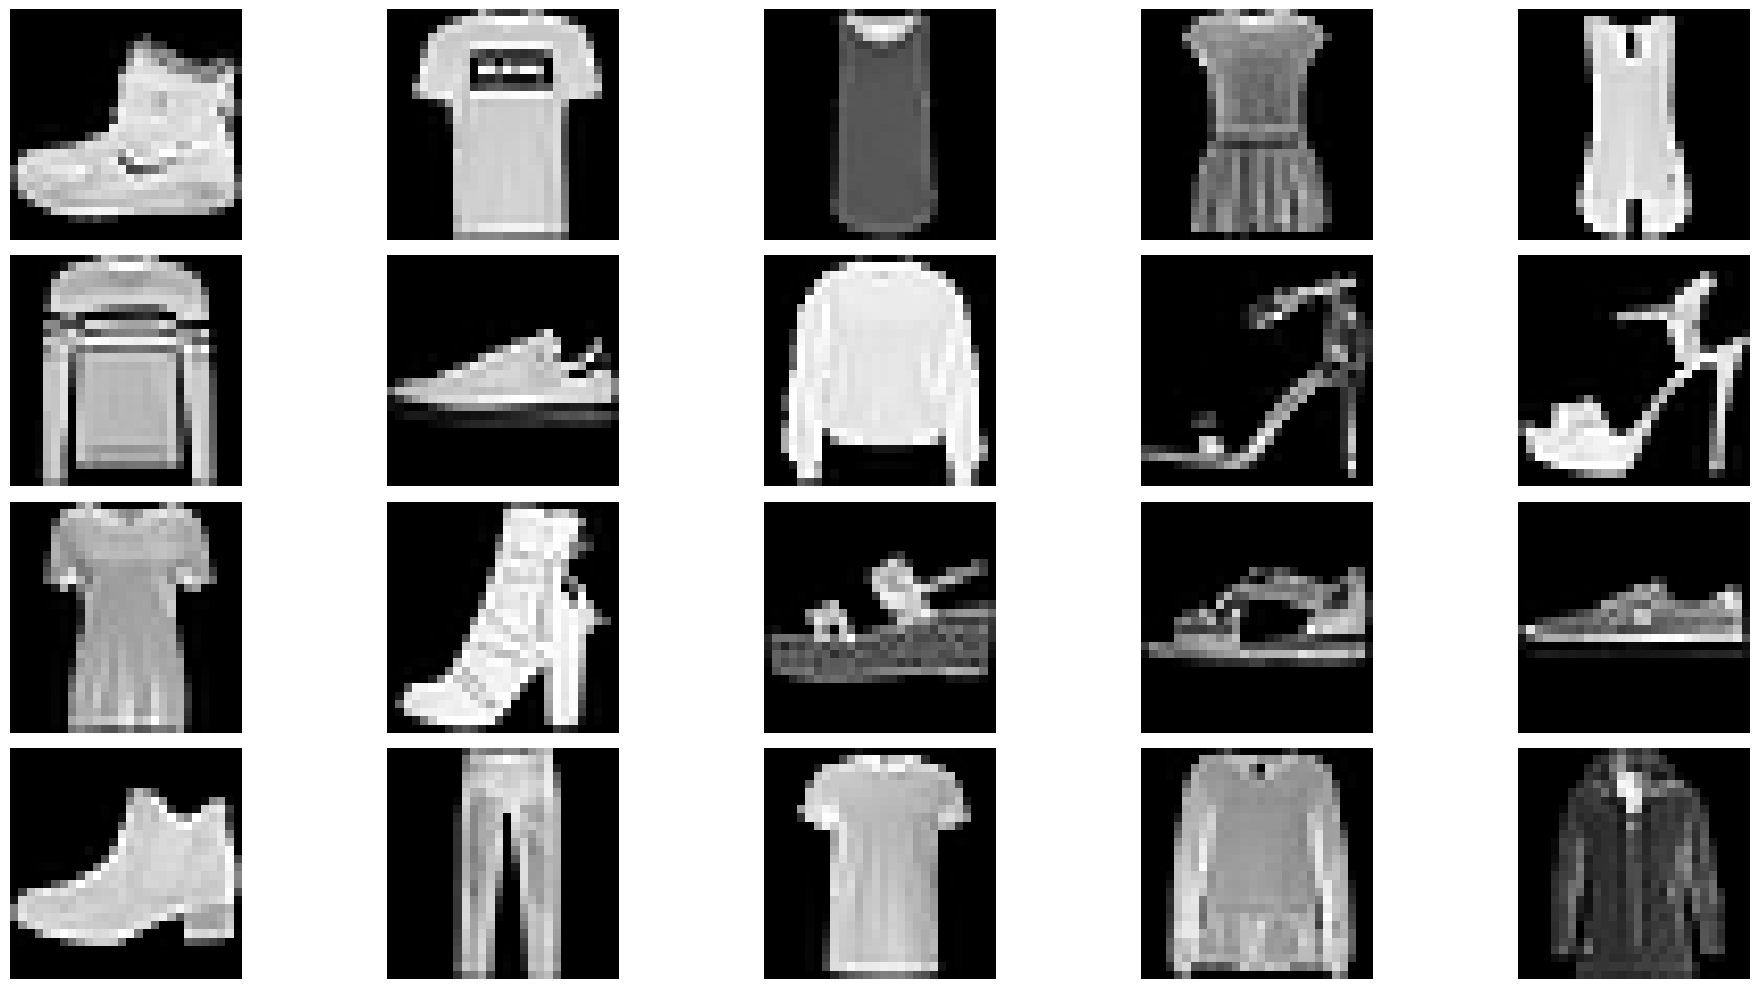

In [3]:
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

plot_images(X_train[:20], 4, 5)

In [4]:
base_model = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(10, activation="softmax", name="output_layer"),
                ]
        )
optimizer = keras.optimizers.Adam(learning_rate=0.02)
base_model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
base_model.summary()

2025-04-04 07:18:51.300230: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-04 07:18:51.300270: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-04 07:18:51.300278: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: 88f2b9b41063
2025-04-04 07:18:51.300283: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: 88f2b9b41063
2025-04-04 07:18:51.300394: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 550.120.0
2025-04-04 07:18:51.300417: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel rep

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
base_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 2s - 947us/step - accuracy: 0.7883 - loss: 0.8262 - val_accuracy: 0.7644 - val_loss: 1.1017
Epoch 2/10
1719/1719 - 1s - 731us/step - accuracy: 0.8103 - loss: 0.8102 - val_accuracy: 0.8104 - val_loss: 0.7084
Epoch 3/10
1719/1719 - 1s - 751us/step - accuracy: 0.8143 - loss: 0.8241 - val_accuracy: 0.8096 - val_loss: 0.8177
Epoch 4/10
1719/1719 - 1s - 744us/step - accuracy: 0.8168 - loss: 0.8110 - val_accuracy: 0.8022 - val_loss: 1.3004
Epoch 5/10
1719/1719 - 1s - 744us/step - accuracy: 0.8215 - loss: 0.8054 - val_accuracy: 0.8144 - val_loss: 0.8821
Epoch 6/10
1719/1719 - 1s - 720us/step - accuracy: 0.8212 - loss: 0.8129 - val_accuracy: 0.8358 - val_loss: 0.7971
Epoch 7/10
1719/1719 - 1s - 748us/step - accuracy: 0.8251 - loss: 0.8110 - val_accuracy: 0.7570 - val_loss: 1.4815
Epoch 8/10
1719/1719 - 1s - 715us/step - accuracy: 0.8205 - loss: 0.8518 - val_accuracy: 0.8122 - val_loss: 0.8795
Epoch 9/10
1719/1719 - 1s - 826us/step - accuracy: 0.8249 - loss: 0.7945 - val_a

In [6]:
base_model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.7867 - loss: 1.1728


[1.2256489992141724, 0.7828999757766724]

In [7]:
model1 = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(5, activation="relu", name="hidden_layer"),
                keras.layers.Dense(10, activation="softmax", name="output_layer"),
                ]
        )
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model1.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 5)              │         3,925 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,985 (15.57 KB)

 Trainable params: 3,985 (15.57 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model1.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 2s - 989us/step - accuracy: 0.3060 - loss: 1.5748 - val_accuracy: 0.3176 - val_loss: 1.4417
Epoch 2/10
1719/1719 - 1s - 741us/step - accuracy: 0.3846 - loss: 1.3704 - val_accuracy: 0.3968 - val_loss: 1.3348
Epoch 3/10
1719/1719 - 1s - 740us/step - accuracy: 0.4257 - loss: 1.3002 - val_accuracy: 0.4496 - val_loss: 1.2675
Epoch 4/10
1719/1719 - 1s - 735us/step - accuracy: 0.4415 - loss: 1.2744 - val_accuracy: 0.4126 - val_loss: 1.3119
Epoch 5/10
1719/1719 - 1s - 776us/step - accuracy: 0.4499 - loss: 1.2602 - val_accuracy: 0.4190 - val_loss: 1.2701
Epoch 6/10
1719/1719 - 1s - 789us/step - accuracy: 0.4601 - loss: 1.2485 - val_accuracy: 0.4682 - val_loss: 1.2711
Epoch 7/10
1719/1719 - 1s - 798us/step - accuracy: 0.4748 - loss: 1.2418 - val_accuracy: 0.4858 - val_loss: 1.2238
Epoch 8/10
1719/1719 - 1s - 752us/step - accuracy: 0.4868 - loss: 1.2337 - val_accuracy: 0.4990 - val_loss: 1.2554
Epoch 9/10
1719/1719 - 2s - 1ms/step - accuracy: 0.4919 - loss: 1.2244 - val_acc

In [9]:
model2 = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(64, activation="selu", name="hidden_layer"),
                keras.layers.Dense(10, activation="softmax", name="output_layer"),
                ]
        )
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model2.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model2.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2, batch_size=32)

Epoch 1/10
1719/1719 - 2s - 1ms/step - accuracy: 0.7749 - loss: 0.7096 - val_accuracy: 0.7866 - val_loss: 0.7426
Epoch 2/10
1719/1719 - 2s - 990us/step - accuracy: 0.8016 - loss: 0.6499 - val_accuracy: 0.8142 - val_loss: 0.6184
Epoch 3/10
1719/1719 - 2s - 962us/step - accuracy: 0.8035 - loss: 0.6758 - val_accuracy: 0.7680 - val_loss: 0.7488
Epoch 4/10
1719/1719 - 2s - 950us/step - accuracy: 0.8114 - loss: 0.6406 - val_accuracy: 0.7938 - val_loss: 0.6992
Epoch 5/10
1719/1719 - 2s - 1ms/step - accuracy: 0.8191 - loss: 0.6234 - val_accuracy: 0.8216 - val_loss: 0.6626
Epoch 6/10
1719/1719 - 2s - 973us/step - accuracy: 0.8177 - loss: 0.6302 - val_accuracy: 0.8256 - val_loss: 0.5377
Epoch 7/10
1719/1719 - 2s - 903us/step - accuracy: 0.8226 - loss: 0.6129 - val_accuracy: 0.7972 - val_loss: 0.6490
Epoch 8/10
1719/1719 - 2s - 1ms/step - accuracy: 0.8221 - loss: 0.6170 - val_accuracy: 0.8024 - val_loss: 0.7484
Epoch 9/10
1719/1719 - 2s - 1ms/step - accuracy: 0.8232 - loss: 0.6331 - val_accuracy:

In [11]:
model2.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8397 - loss: 0.5846


[0.5961727499961853, 0.8378999829292297]

# Autoencoder

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


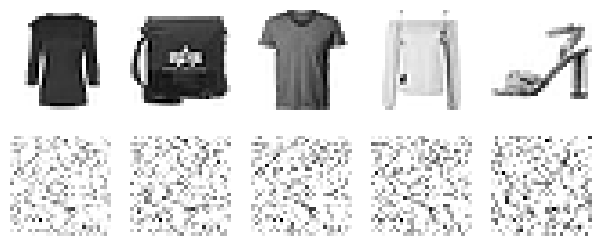

In [12]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(100, activation="relu"),
                keras.layers.Dense(10, activation="relu"),
                ]
        )
stacked_decoder = keras.Sequential(
        [
                keras.layers.Input(shape=[10]),
                keras.layers.Dense(100, activation="relu"),
                keras.layers.Dense(28 * 28),
                keras.layers.Reshape([28, 28])
                ]
        )
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(
        loss="binary_crossentropy", optimizer=keras.optimizers.Adam()
        )
plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 2s - 5ms/step - loss: 0.8016 - val_loss: 0.6983
Epoch 2/10
430/430 - 1s - 3ms/step - loss: 0.6808 - val_loss: 0.6741
Epoch 3/10
430/430 - 1s - 3ms/step - loss: 0.6524 - val_loss: 0.6401
Epoch 4/10
430/430 - 1s - 3ms/step - loss: 0.6185 - val_loss: 0.6141
Epoch 5/10
430/430 - 1s - 3ms/step - loss: 0.5973 - val_loss: 0.5855
Epoch 6/10
430/430 - 1s - 3ms/step - loss: 0.6273 - val_loss: 0.6219
Epoch 7/10
430/430 - 1s - 3ms/step - loss: 0.6109 - val_loss: 0.6319
Epoch 8/10
430/430 - 1s - 3ms/step - loss: 0.6018 - val_loss: 0.5979
Epoch 9/10
430/430 - 1s - 3ms/step - loss: 0.5859 - val_loss: 0.5883
Epoch 10/10
430/430 - 1s - 3ms/step - loss: 0.6208 - val_loss: 0.6015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


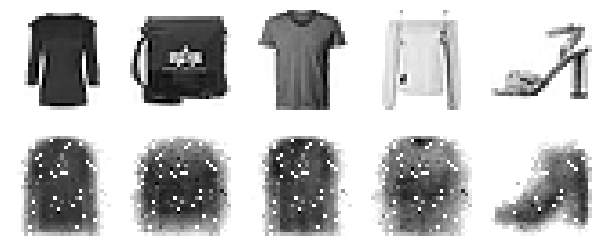

In [13]:
stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
plot_reconstructions(stacked_ae, images=X_valid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


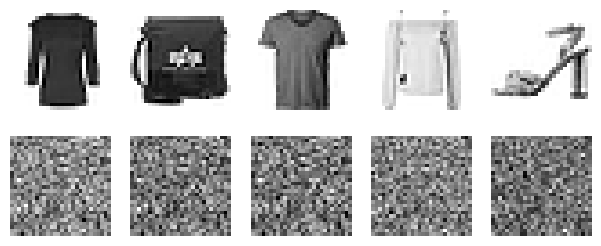

In [14]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


code_size = 9
stacked_encoder = keras.models.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(14 * 14, activation="selu"),
                keras.layers.Dense(code_size, activation="selu"),
                ]
        )
stacked_decoder = keras.models.Sequential(
        [
                keras.layers.Input(shape=[code_size]),
                keras.layers.Dense(196, activation="selu"),
                keras.layers.Dense(28 * 28, activation="sigmoid"),
                keras.layers.Reshape([28, 28])
                ]
        )
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
loss = "binary_crossentropy"
stacked_ae.compile(
        loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
        )
plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 2s - 5ms/step - loss: 0.4065 - rounded_accuracy: 0.8280 - val_loss: 0.3564 - val_rounded_accuracy: 0.8774
Epoch 2/10
430/430 - 2s - 4ms/step - loss: 0.3429 - rounded_accuracy: 0.8829 - val_loss: 0.3427 - val_rounded_accuracy: 0.8870
Epoch 3/10
430/430 - 2s - 4ms/step - loss: 0.3320 - rounded_accuracy: 0.8916 - val_loss: 0.3304 - val_rounded_accuracy: 0.8924
Epoch 4/10
430/430 - 2s - 4ms/step - loss: 0.3267 - rounded_accuracy: 0.8961 - val_loss: 0.3258 - val_rounded_accuracy: 0.8966
Epoch 5/10
430/430 - 2s - 4ms/step - loss: 0.3234 - rounded_accuracy: 0.8987 - val_loss: 0.3231 - val_rounded_accuracy: 0.8988
Epoch 6/10
430/430 - 2s - 4ms/step - loss: 0.3211 - rounded_accuracy: 0.9005 - val_loss: 0.3217 - val_rounded_accuracy: 0.8995
Epoch 7/10
430/430 - 2s - 4ms/step - loss: 0.3194 - rounded_accuracy: 0.9017 - val_loss: 0.3206 - val_rounded_accuracy: 0.9002
Epoch 8/10
430/430 - 2s - 4ms/step - loss: 0.3180 - rounded_accuracy: 0.9028 - val_loss: 0.3199 - val_rounded_a

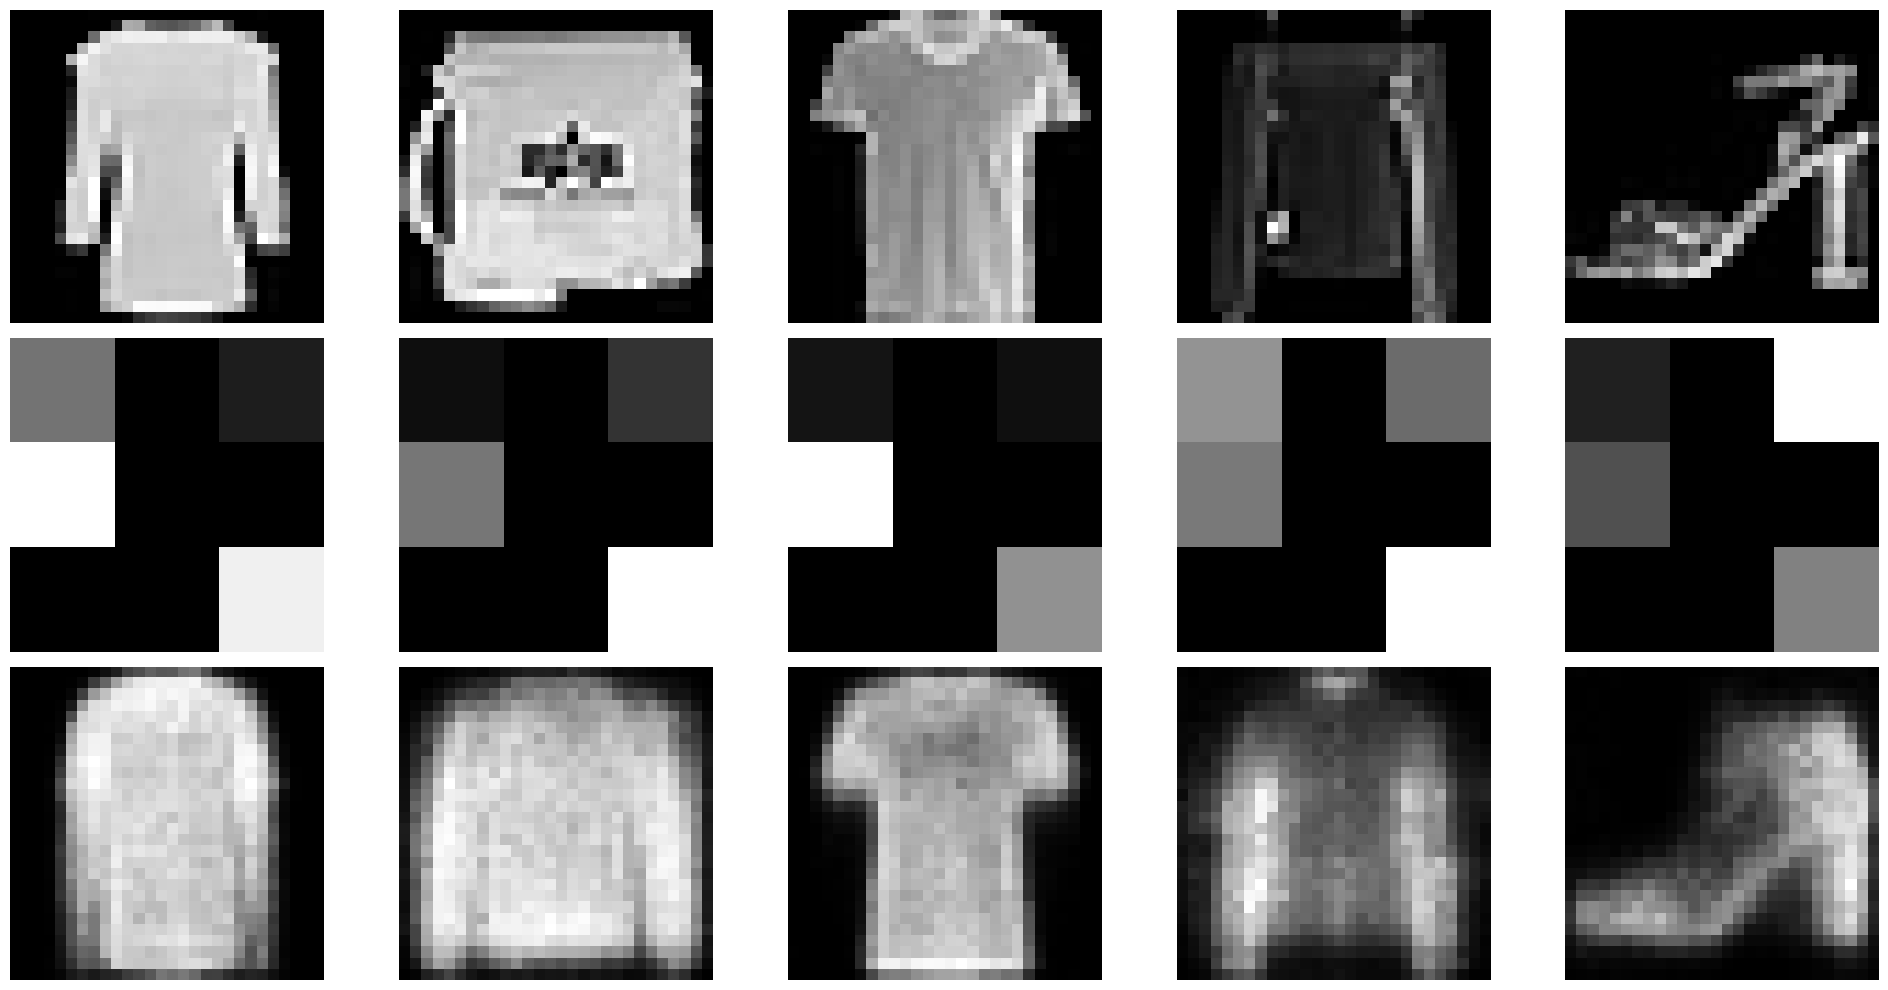

In [15]:
stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
show_reconstructions_code(stacked_ae, X_valid, (3, 3), 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


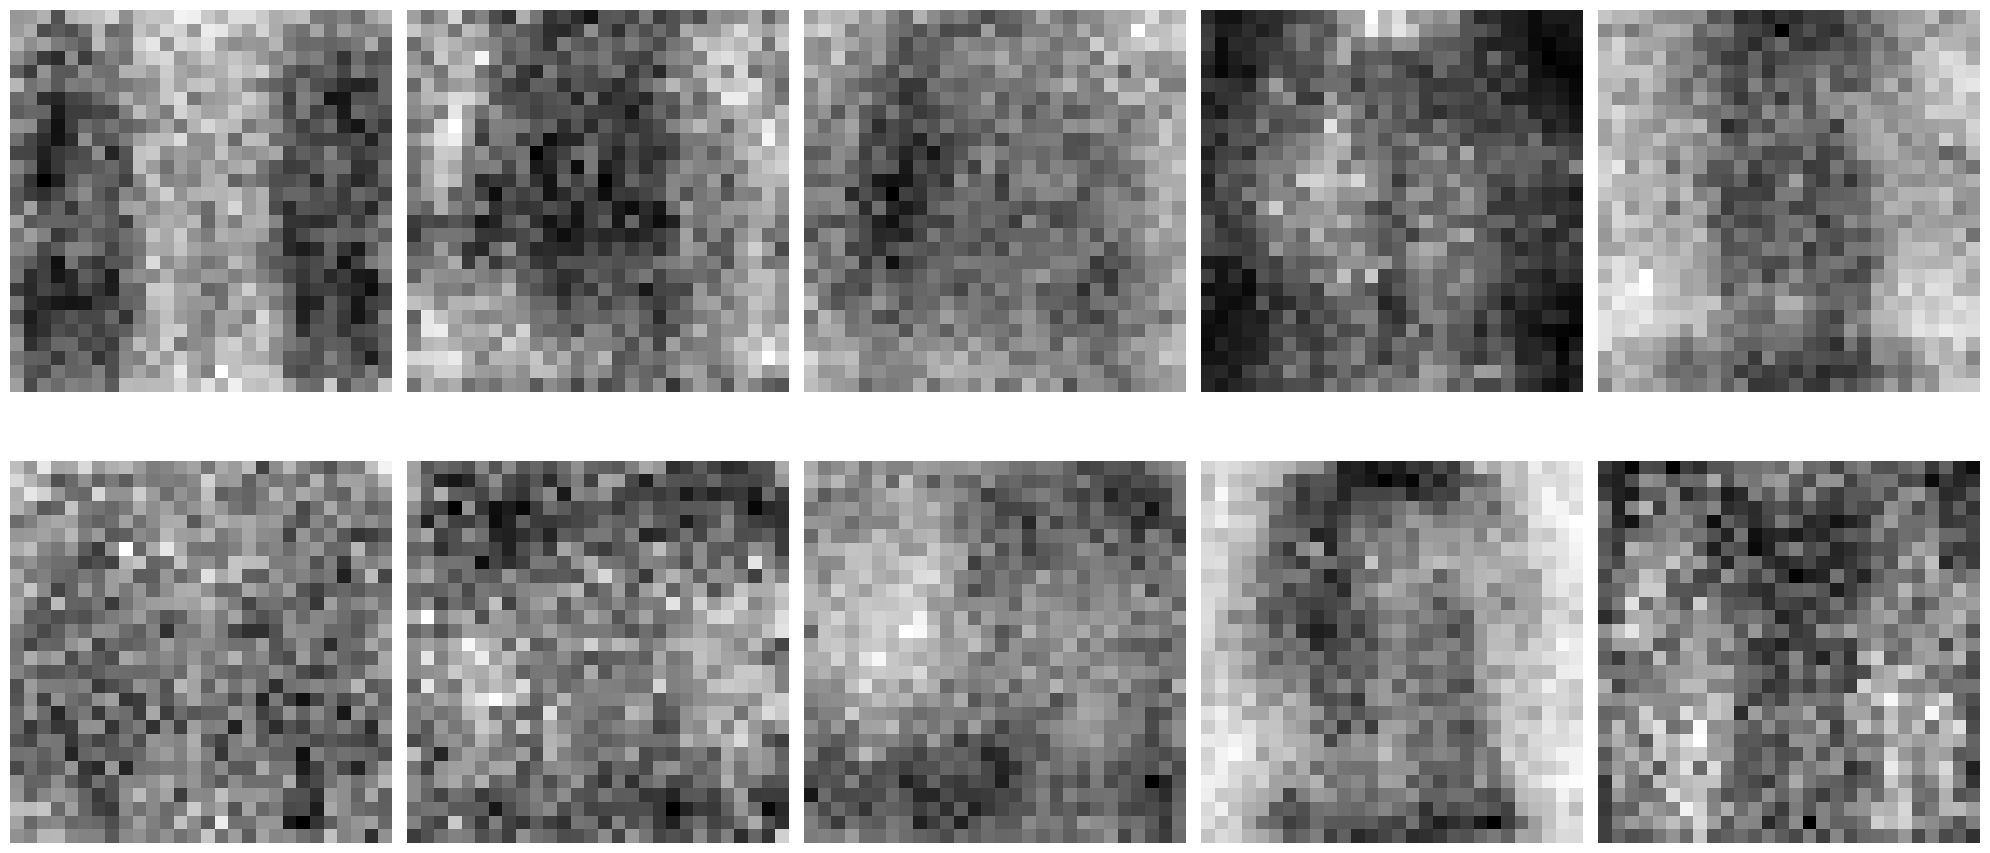

In [16]:
X_code = np.random.normal(size=(10, code_size))
images = stacked_decoder.predict(X_code)
plot_images(images, 2, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


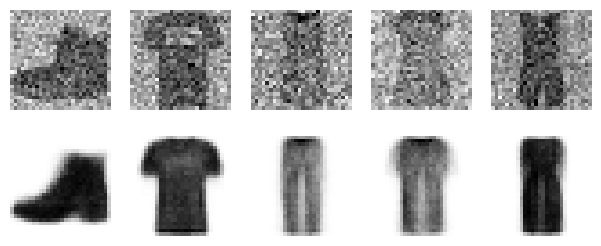

In [17]:
noise = keras.layers.GaussianNoise(0.3)
X_noise = noise(X_train, training=True).numpy()
plot_reconstructions(stacked_ae, images=X_noise[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


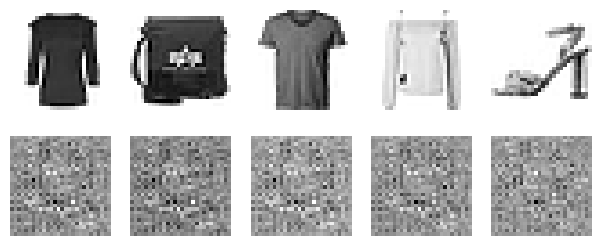

In [18]:
conv_encoder_2 = keras.models.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Reshape([28, 28, 1]),
                keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2),
                keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2),
                keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2),
                keras.layers.Flatten(),
                keras.layers.Dense(code_size)
                ]
        )
conv_decoder_2 = keras.models.Sequential(
        [
                keras.layers.Dense(code_size * 64),
                keras.layers.Reshape([3, 3, 64], input_shape=[3 * 3 * 64]),
                keras.layers.Conv2DTranspose(
                        32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                        input_shape=[3, 3, 64]
                        ),
                keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
                keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
                keras.layers.Reshape([28, 28])
                ]
        )
conv_ae_2 = keras.models.Sequential([conv_encoder_2, conv_decoder_2])

conv_ae_2.compile(
        loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
        metrics=[rounded_accuracy]
        )
plot_reconstructions(conv_ae_2, images=X_valid)

Epoch 1/10
430/430 - 6s - 13ms/step - loss: 0.3825 - rounded_accuracy: 0.8508 - val_loss: 0.3320 - val_rounded_accuracy: 0.8914
Epoch 2/10
430/430 - 5s - 12ms/step - loss: 0.3191 - rounded_accuracy: 0.9019 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 3/10
430/430 - 5s - 12ms/step - loss: 0.3099 - rounded_accuracy: 0.9100 - val_loss: 0.3084 - val_rounded_accuracy: 0.9141
Epoch 4/10
430/430 - 5s - 12ms/step - loss: 0.3058 - rounded_accuracy: 0.9129 - val_loss: 0.3095 - val_rounded_accuracy: 0.9124
Epoch 5/10
430/430 - 5s - 12ms/step - loss: 0.3031 - rounded_accuracy: 0.9148 - val_loss: 0.3067 - val_rounded_accuracy: 0.9143
Epoch 6/10
430/430 - 5s - 11ms/step - loss: 0.3011 - rounded_accuracy: 0.9163 - val_loss: 0.3022 - val_rounded_accuracy: 0.9166
Epoch 7/10
430/430 - 5s - 12ms/step - loss: 0.2997 - rounded_accuracy: 0.9172 - val_loss: 0.3037 - val_rounded_accuracy: 0.9165
Epoch 8/10
430/430 - 5s - 12ms/step - loss: 0.2984 - rounded_accuracy: 0.9183 - val_loss: 0.3032 - val_r

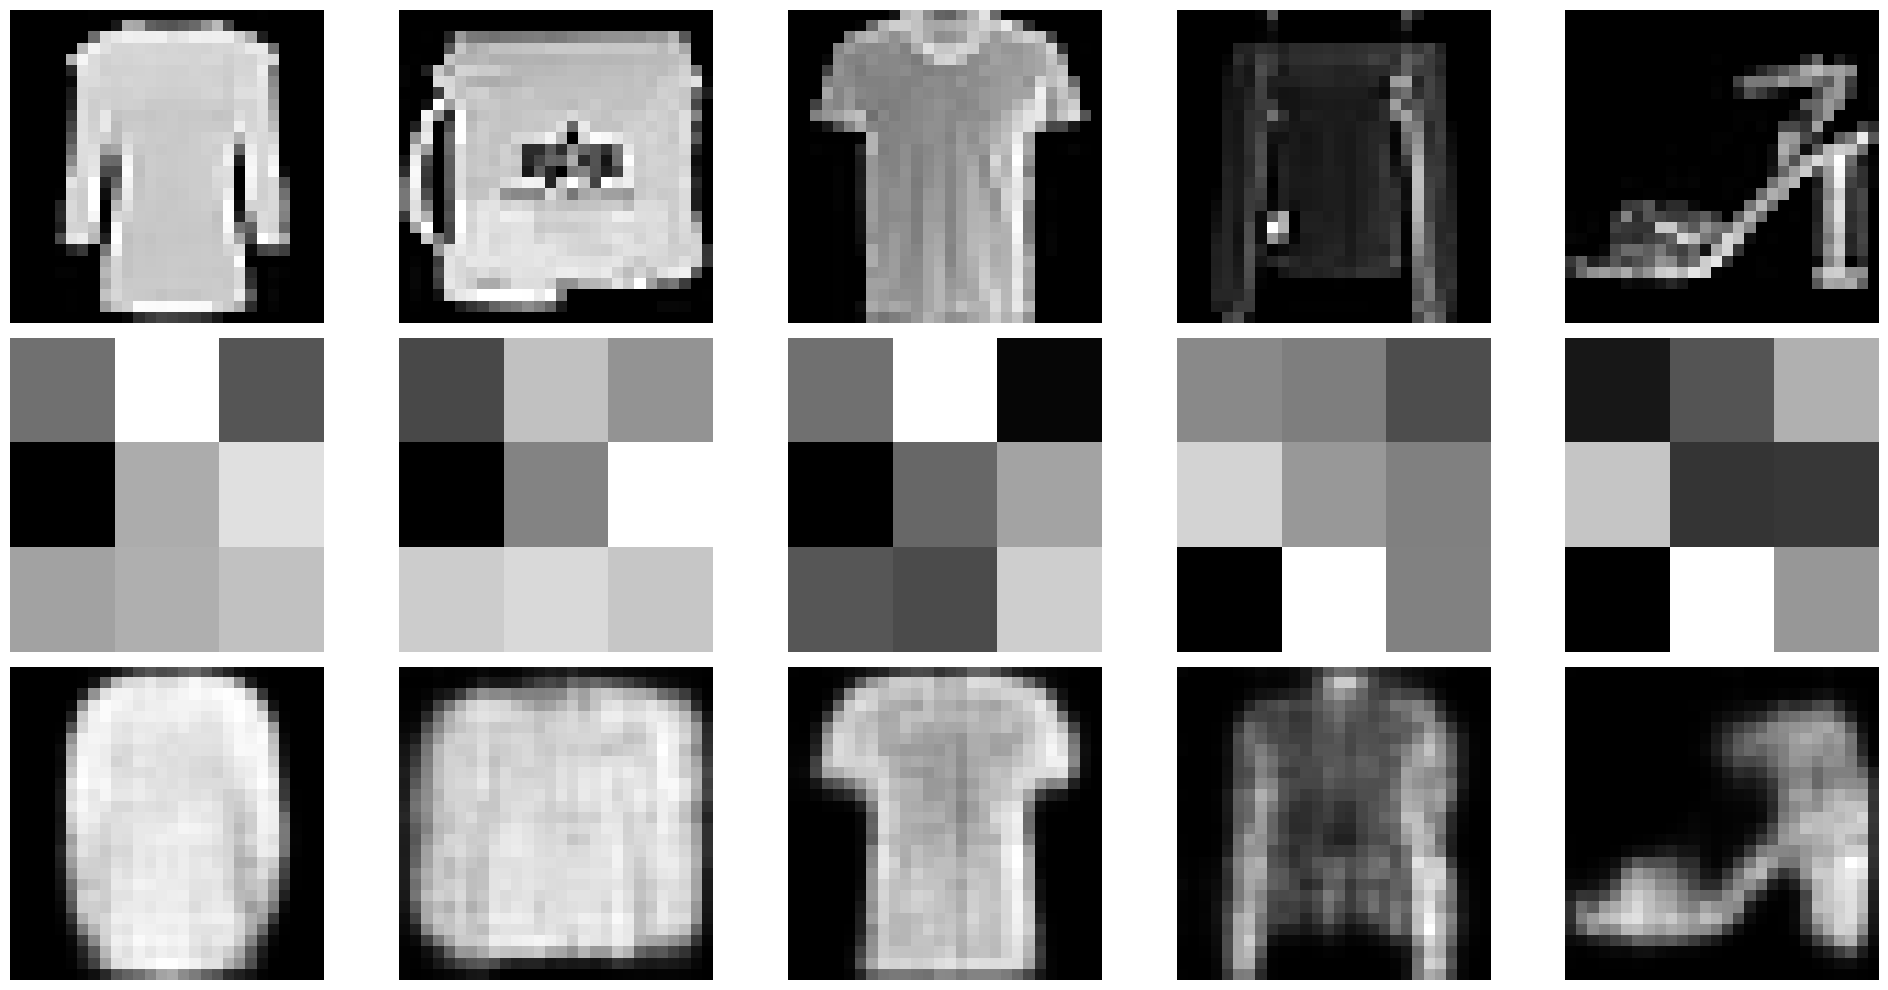

In [19]:
conv_ae_2.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
show_reconstructions_code(conv_ae_2, X_valid, (3, 3), 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


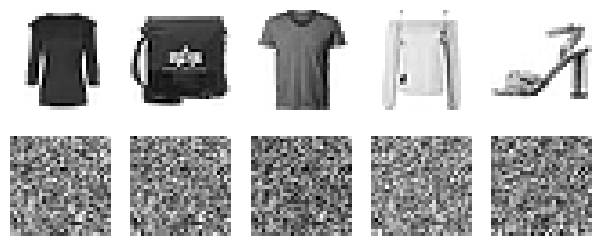

In [20]:
code_size = 64
stacked_encoder1 = keras.models.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(14 * 14, activation="selu"),
                keras.layers.Dense(code_size, activation="selu"),
                ]
        )
stacked_decoder1 = keras.models.Sequential(
        [
                keras.layers.Input(shape=[code_size]),
                keras.layers.Dense(196, activation="selu"),
                keras.layers.Dense(28 * 28, activation="sigmoid"),
                keras.layers.Reshape([28, 28])
                ]
        )
stacked_ae1 = keras.models.Sequential([stacked_encoder1, stacked_decoder1])
loss = "binary_crossentropy"
stacked_ae1.compile(
        loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
        )
plot_reconstructions(stacked_ae1, images=X_valid)

Epoch 1/20
430/430 - 3s - 6ms/step - loss: 0.3731 - rounded_accuracy: 0.8573 - val_loss: 0.3268 - val_rounded_accuracy: 0.8988
Epoch 2/20
430/430 - 2s - 5ms/step - loss: 0.3193 - rounded_accuracy: 0.9044 - val_loss: 0.3149 - val_rounded_accuracy: 0.9097
Epoch 3/20
430/430 - 2s - 4ms/step - loss: 0.3100 - rounded_accuracy: 0.9124 - val_loss: 0.3093 - val_rounded_accuracy: 0.9162
Epoch 4/20
430/430 - 2s - 4ms/step - loss: 0.3044 - rounded_accuracy: 0.9171 - val_loss: 0.3031 - val_rounded_accuracy: 0.9199
Epoch 5/20
430/430 - 2s - 4ms/step - loss: 0.3005 - rounded_accuracy: 0.9207 - val_loss: 0.2997 - val_rounded_accuracy: 0.9227
Epoch 6/20
430/430 - 2s - 4ms/step - loss: 0.2973 - rounded_accuracy: 0.9236 - val_loss: 0.2972 - val_rounded_accuracy: 0.9261
Epoch 7/20
430/430 - 2s - 4ms/step - loss: 0.2948 - rounded_accuracy: 0.9260 - val_loss: 0.2945 - val_rounded_accuracy: 0.9280
Epoch 8/20
430/430 - 2s - 4ms/step - loss: 0.2926 - rounded_accuracy: 0.9281 - val_loss: 0.2927 - val_rounded_a

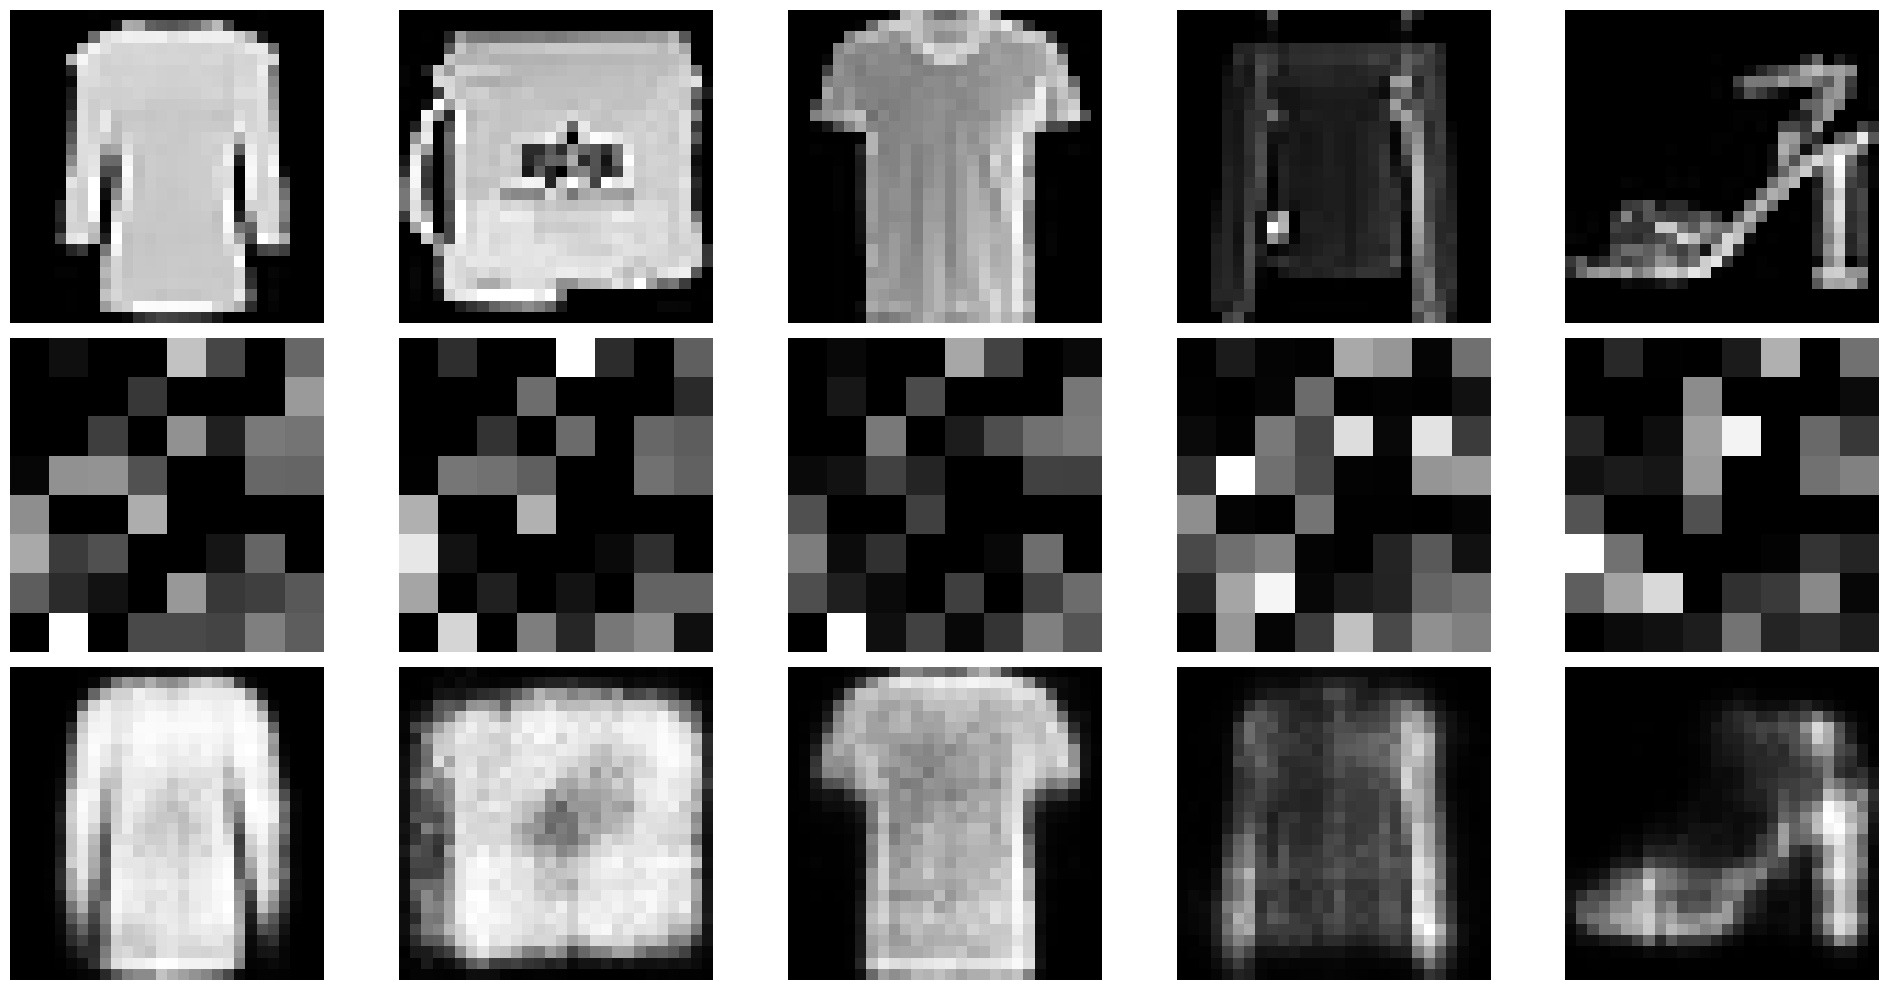

In [21]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=0.002, patience=2,
        mode='auto',
        verbose=True,
        restore_best_weights=True
        )
stacked_ae1.fit(
        X_train, X_train, epochs=20, validation_data=(X_valid, X_valid), verbose=2, batch_size=128,
        callbacks=[early_stopping]
        )
show_reconstructions_code(stacked_ae1, X_valid, (8, 8), 5)


In [22]:
(mnist_images, mnist_labels), (mnist_images_test, mnist_labels_test) = keras.datasets.mnist.load_data()
X_train_digits = tf.cast(mnist_images / 255, tf.float32)
y_train_digits = tf.cast(mnist_labels, tf.int64)


In [23]:
ds = tf.data.Dataset.from_tensor_slices((X_train_digits, y_train_digits))
for x, y in ds.take(2):
    print(f"x.shape: {x.shape}, y: {y.shape}")

x.shape: (28, 28), y: ()
x.shape: (28, 28), y: ()


2025-04-04 07:21:33.255893: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
ds_fashion = tf.data.Dataset.from_tensor_slices((X_train[:10_000], y_train[:10_000]))
ds_negative = ds_fashion.map(lambda x, y: (x, tf.constant(10, tf.int64)))
ds = ds.concatenate(ds_negative)
ds = ds.shuffle(1000).batch(128)

In [25]:
model = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(name="input_layer"),
                keras.layers.Dense(20, activation="relu", name="hidden_layer"),
                keras.layers.Dense(11, activation="softmax", name="output"),
                ]
        )
model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer="adam",
        metrics=["accuracy"]
        )
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 11)             │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,931 (62.23 KB)

 Trainable params: 15,931 (62.23 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.fit(ds, epochs=10, verbose=2)

Epoch 1/10
547/547 - 1s - 2ms/step - accuracy: 0.8411 - loss: 0.6149
Epoch 2/10
547/547 - 0s - 860us/step - accuracy: 0.8995 - loss: 0.3534
Epoch 3/10
547/547 - 0s - 879us/step - accuracy: 0.9281 - loss: 0.2566
Epoch 4/10
547/547 - 0s - 858us/step - accuracy: 0.9368 - loss: 0.2252
Epoch 5/10
547/547 - 0s - 854us/step - accuracy: 0.9421 - loss: 0.2055
Epoch 6/10
547/547 - 0s - 865us/step - accuracy: 0.9465 - loss: 0.1885
Epoch 7/10
547/547 - 0s - 866us/step - accuracy: 0.9507 - loss: 0.1737
Epoch 8/10
547/547 - 0s - 863us/step - accuracy: 0.9545 - loss: 0.1615
Epoch 9/10
547/547 - 0s - 853us/step - accuracy: 0.9571 - loss: 0.1508
Epoch 10/10
547/547 - 0s - 860us/step - accuracy: 0.9594 - loss: 0.1420


In [27]:
model.predict(X_valid[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[1.8878677e-16, 8.8934177e-28, 5.2595558e-13, 1.5164113e-17,
        2.8758640e-33, 6.4355882e-11, 8.5731345e-20, 1.5675725e-22,
        2.3884939e-22, 2.9468880e-30, 1.0000000e+00],
       [5.3329407e-26, 2.2320712e-36, 3.7621109e-18, 4.9514964e-22,
        0.0000000e+00, 1.1887526e-16, 5.0734460e-29, 2.0620433e-31,
        8.3099862e-31, 0.0000000e+00, 1.0000000e+00],
       [6.8436467e-23, 2.0002513e-28, 3.1097165e-14, 1.5699249e-21,
        2.2753330e-34, 1.2180948e-16, 1.5441564e-25, 3.9533435e-22,
        6.2881213e-28, 6.5947028e-34, 1.0000000e+00],
       [1.7721404e-03, 1.0057028e-05, 9.6436990e-03, 5.4105688e-03,
        3.6454250e-05, 8.0828164e-03, 6.7490095e-04, 5.2609183e-05,
        5.6588880e-05, 4.6818695e-06, 9.7425544e-01],
       [1.1529887e-05, 3.7411246e-12, 2.4198607e-04, 1.2254857e-09,
        6.6417645e-13, 2.3242981e-06, 5.0835285e-07, 2.7648970e-11,
        2.5078165e-10, 1.0401884e-14, 9.9974364e-01],
       [1.4862237e-34, 0.0000000e+00, 3.2515971e-2

In [28]:
model.predeict(X_train_digits[10:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[4.54969999e-08, 2.47924145e-05, 3.73524995e-06, 9.99352753e-01,
        3.99316908e-12, 2.85180504e-05, 1.54168984e-12, 2.08411208e-07,
        5.45063704e-05, 5.34678285e-04, 7.34998991e-07],
       [4.78007132e-04, 1.20454897e-04, 3.67302075e-03, 2.09524157e-03,
        1.53609295e-03, 9.89884019e-01, 9.79022589e-04, 5.94256107e-06,
        2.63671885e-04, 1.61626076e-06, 9.62953432e-04],
       [3.14385930e-12, 9.89816318e-09, 1.49357987e-07, 9.99999046e-01,
        4.82426090e-14, 1.38371931e-07, 6.86170464e-15, 5.90995839e-08,
        4.00730755e-08, 3.82269825e-08, 4.78384663e-07],
       [2.52319842e-05, 5.80737890e-07, 7.19725038e-04, 6.60507658e-06,
        4.91552230e-04, 1.08836131e-04, 9.98636663e-01, 1.40981376e-06,
        1.62675883e-06, 9.54667485e-07, 6.78940023e-06],
       [5.29711315e-07, 9.93494093e-01, 1.04978513e-04, 1.12009700e-03,
        1.72199964e-06, 4.82636642e-05, 2.50501937e-04, 1.46551334e-04,
        4.82533360e-03, 6.84153656e-06, 1.02662239e-